<a href="https://colab.research.google.com/github/dikshank/Transformer-From-Scratch/blob/main/Transformer_for_English_to_Hindi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here I am trying to implement A Transformer model, just like the one used in "Attention is all you need paper" for machine translation task

In [ ]:
# importing necessary libraries
import tensorflow as tf
from tensorflow import convert_to_tensor, string
from tensorflow.keras.layers import TextVectorization, Embedding, Layer
import numpy as np
from tensorflow import matmul, math, cast, float32, newaxis
from keras.backend import softmax

## Positional Embedding + Word Embedding Implementation

This is the initial part of a transformer where it takes input and converts it into word embeddings and then adds the positional information in the created word embeddings

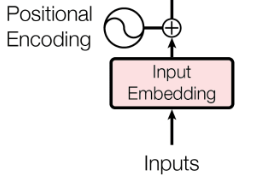

The inputs here represent the numerical tokens of the source language. For example let's say you have a sentence <font color='orange'>**['It is a nice place']**</font>, then this will be preprocessed and we will finally convert it to a number vector like <font color='orange'>**[2,3,4,5,6]**</font> where each number is just index of our word and this numbering is based on the tokenizer we use.

<font color='cyan'>**THE LOGIC BEHIND POSITIONAL ENCODING**</font>

Transformers are unable to get the sequence of a sentence because, unlike RNNs where we pass the sentence, in transformer we pass the complete sentence all at once so transformer have almost no understanding of the positions of these words inside sentence.

The Positional encoding are some number that we add in our word emebeddings. Let's say we have two word **car** and **vechicle**, when we have "perfect" word embeddings for both these words then we should definately see some similarity between these, because both of the words are obviously similar. And When we add positional encoding to our word embeddings then obviously these embeddings will change. So we must add positional encodings that are not too larger because we don't want to change the sementic similarity among different words by adding large numbers of position and irrespective of what word comes first, our positional encoding should remain the same. In other words, our positional encoding must not depend of the type of the word we have at any index.
One possible solution what the the authors of 'Attention is all you need" applied, which is using sin and cosine function to get the positional embeddings.

For even indices in the dimension:
$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$$

For odd indices in the dimension:
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$$

$\text{pos is position of the word}$ <br>
$ \text{i is index of embedding} $ <br>
$d_{model}\ \text{is dimension of our word embedding which is usually 512, but that can vary if you are using pretrained word embeddings}$<br>
$\text{The interger 10000 is represented as n}$


Let's see this in more detail by plotting these functions

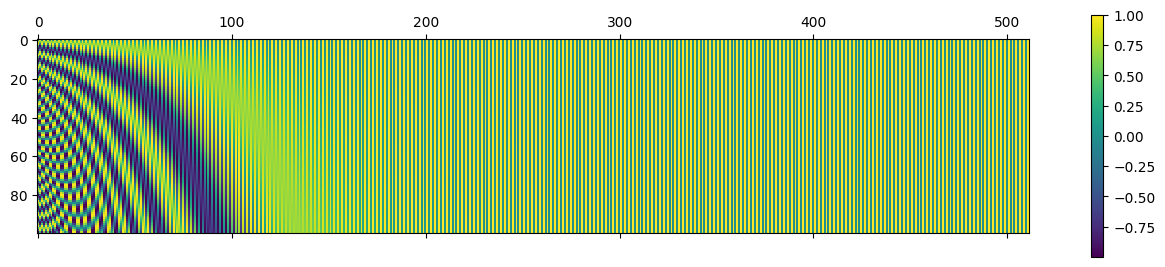

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_positional_encodings(pos, dim, n):
    # Create a placeholder for our encodings
    encodings = np.zeros((len(pos), dim))
    # Loop over each position and dimension
    for p in range(len(pos)):
        for i in range(dim):
            denominator = np.power(n, 2*i/dim)
            if i % 2 == 0: # For even 'i', use sin
                encodings[p,i] = np.sin(pos[p]/denominator)
            else:          # For odd 'i', use cos
                encodings[p,i] = np.cos(pos[p]/denominator)
    return encodings

# Generate encodings for positions 0 through 100
pos = np.arange(100)
P = get_positional_encodings(pos, dim=512, n=10000)

# Visualize the encodings
cax = plt.matshow(P)
plt.gcf().colorbar(cax)
plt.show()

A small portion of this will look like:

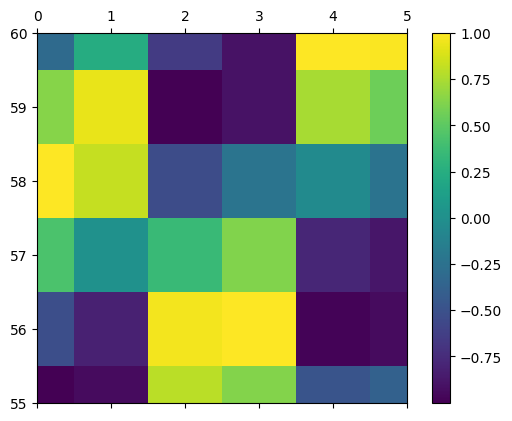

In [ ]:
# Visualize the encodings
fig, ax = plt.subplots()
cax = ax.matshow(P)
fig.colorbar(cax)
ax.set_ylim(0, 5)
ax.set_xlim(0, 5)
plt.show()

So at first glance on the big picture looks the same but when we see a portion of it, then it becomes clear that positional encoding are doing a good job at setting apart the word sequences but within a range (we don't want our positional encoding to overpower the actual embeddings)

Then we will add this $(100,512)$ positional encoding (where 100 is sequence length, a.k.a total words in our sequence).

<font color='red'>NOTE</font>:

* <font color='brown'>ADDING is not the only option if we want to encode the positional information to the word embeddings, we can also CONCATENATE the positional encoding to the word embeddings and the resulting shape will be (100, 1024) considering 512 is the dimension size for both the word embedding and postional embedding.</font>

* <font color='brown'>Using Concatenation we give whole new dimensions to the positional information where it can live at the cost of computational resources, because for obvious reasons the higher dimensional input will require more computation than its counterpart.
</font>

* <font color='brown'> Another method could be to just let the model figure out the positional embeddings during training</font>

In this implementation I am gonna intialize the positional encoding using the formula discussed above and then during training I will let the Transformer figure out the necessary changes that should be made to the encoding.

In [ ]:
# positiona encoding + Word embedding ==> Positional embedding
class PositionalEmbeddingLayer(Layer):

  def __init__(self, seq_length, vocab_size, output_dim, pretrained_embedding_matrix, **kwargs):

    super().__init__(**kwargs)
    self.seq_length = seq_length

    if pretrained_embedding_matrix is not None:
      self.word_embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dim, weights=[pretrained_embedding_matrix], trainable=True)

    # If you are not using any pretrained word embeddings then just initialise the "Word embeddings" using the get_position_encoding, just for starters and #
    #  the model will learn the actual word embedding during training, you can also not give any weights parameter if you don't want to that is also perfectly fine
    else:
      word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim)
      self.word_embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dim, weights=[word_embedding_matrix], trainable=True)

    pos_embedding_matrix = self.get_position_encoding(seq_length, output_dim)
    self.position_embedding_layer = Embedding(input_dim=seq_length, output_dim=output_dim, weights=[pos_embedding_matrix], trainable=True)


  def get_position_encoding(self, seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
      for i in np.arange(int(d/2)):
        denominator = np.power(n, 2*i/d)
        P[k, 2*i] = np.sin(k/denominator)
        P[k, 2*i+1] = np.cos(k/denominator)
    return P


  def call(self, inputs):
    embedded_words = self.word_embedding_layer(inputs)

    position_indices = tf.range(tf.shape(inputs)[-1])    # inputs are (batch size, sequence length) so this will extract the sequence length
    embedded_indices = self.position_embedding_layer(position_indices)  # We will pass the position_indices in the position_embedding_layer and this will return the postional encoding

    return embedded_words + embedded_indices

# Multihead Attention Implementation

From now on we will assume the shape of inputs and outputs to better understand things.

Suppose the input to the word embedding layer was $(256, 6)$ where $256$ is batch size and $6$ is sequence length (i.e. number of words in each batch of sentence).

After passing this through the Word Embedding layer we will get $(256, 6, 512)$, where $512$ is the dimension of word embeddding.

And for this we will get a positional encoding of shape $(6, 512)$ and then we will add this in the Word embedding that we got from word embedding layer. (Don't worry about the shapes not matching because the tensoflow will add this broadcasting, meaning this positional encoding of shape $(6, 512)$ will be logically converted to $(256, 6, 512)$ without duplicating the whole thing $256$ times in the actual memory.

All is good till now.

Now We pass this Postional embedding through 3 different linear layers (with `units=64`) and the output of these linear layers are Query matrix, Key matrix and Value matrix, All three are different matrices and the shape of these matrices are $(256, 6, 64)$

We use Q, K, and V matrices and pass them through multihead attention layer. Things get trickier here.

Let's first understand what a single head does:
A single head will matrix multiply **Query @ key**, and this will be attention matrix which then will be passed through a **softmax** layer and then it will be divided by $\sqrt{(d_k)}$ to normalise the attention weights (i.e. values inside the attention matrix) and then multiplied to **value** matrix to get the context aware embedding. In other words, $\frac{softmax(Q*K)}{\sqrt{(d_k)}}*V$. This is also know as <font color='red orange'>Scaled Dot Product Attention</font>


## Scaled Dot product Attention Implementation (basically $\frac{softmax(Q*K)}{\sqrt{(d_k)}}*V)$

In [ ]:
# Implementing the Scaled-Dot Product Attention
class DotProductAttention(Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, queries, keys, values, d_k, mask=None):
    # Scoring the queries against the keys after transposing the latter, and scaling
    scores = matmul(queries, keys, transpose_b=True) / math.sqrt(cast(d_k, float32))
    # Apply mask to the attention scores
    if mask is not None:
      scores += -1e9 * mask

    # Computing the weights by a softmax operation
    weights = softmax(scores)
    # Computing the attention by a weighted
    return matmul(weights, values)

<font color='brown'> What is this mask?</font>
Let's see

## Understanding padded mask in encoder

Let's say we have sentence after parting it into tokens <font color='brown'>`['i', 'am', 'not', 'home']`</font>, But the fixed length of our sentences is $6$, So we need to add padding to it. So the padded sentence will be <font color='brown'>`['i', 'am', 'not', 'home', '<PAD>', '<PAD>']`</font>.

And the number tokenisation of this is let's say <font color='brown'>`[2, 3, 4, 5, 1, 1]`</font> ( 1 is for `<pad>` token )



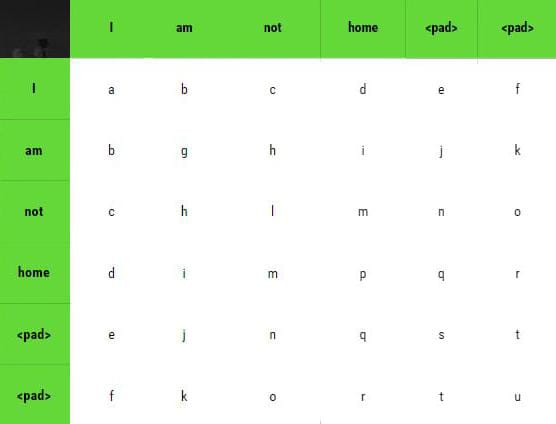

let's assume these (a, b, c, ...etc.) are the attention weights for single head after multiplying Q and K.
Our Transformer model's embedding layer will surely generate some embedding for the `<pad>` tokens and we will see some number at those places in our attention matrix but how can something that isn't even present in our original sentence affect our sentence attention weights. And to deal with that we use **a mask and softmax function**.

Let's better understand through a code

In [ ]:
# understanding pad masking in encoder for a single sentence
import numpy as np
import tensorflow as tf
from tensorflow import math, cast, float64

# A sentence after numerical tokenisation with padding and since we also have a batchsize, the overall shape will be (1,6)
numerical_tokens = np.array([[2, 3, 4, 5, 0, 0]])
print('batch of ', numerical_tokens.shape)

token_embeddings = np.random.rand(6, 10)   # just assuming that word embeddings are these

# and for time being let's also assume that Q, K, V matrices are same
Q = token_embeddings
K = token_embeddings
V = token_embeddings

print('shape of Q, K, V matrices', token_embeddings.shape, '\n')

# this will be a boolean masl
padding_mask = math.equal(numerical_tokens, 0)
# convert the boolean mask to float
padding_mask = cast(padding_mask, float64)

print('padding mask', padding_mask, '\n')

# Creating attention matrix
attn_matrix = tf.matmul(token_embeddings, token_embeddings, transpose_b = True)/ math.sqrt(cast(Q.shape[-1], float64))
print(attn_matrix)

batch of  (1, 6)
shape of Q, K, V matrices (6, 10) 

padding mask tf.Tensor([[0. 0. 0. 0. 1. 1.]], shape=(1, 6), dtype=float64) 

tf.Tensor(
[[0.85602937 0.8813035  0.72835733 0.69541554 0.8355441  0.52364383]
 [0.8813035  1.66855358 0.87635641 0.71701176 1.290503   1.08002225]
 [0.72835733 0.87635641 1.14048092 0.77468035 0.91307326 0.83574975]
 [0.69541554 0.71701176 0.77468035 0.74017991 0.78584037 0.54797597]
 [0.8355441  1.290503   0.91307326 0.78584037 1.23197424 0.82589949]
 [0.52364383 1.08002225 0.83574975 0.54797597 0.82589949 1.14625586]], shape=(6, 6), dtype=float64)


In [ ]:
# Now we multiply the padding mask with almost negative infinite value that is -1e9

padding_mask = padding_mask * (-1e9)
print(padding_mask, '\n')

# Let's now add this padding mask to our attention matrix
masked_attn_matrix = attn_matrix + padding_mask
print(masked_attn_matrix)

tf.Tensor([[-0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09 -1.e+09]], shape=(1, 6), dtype=float64) 

tf.Tensor(
[[ 8.56029373e-01  8.81303497e-01  7.28357328e-01  6.95415542e-01
  -9.99999999e+08 -9.99999999e+08]
 [ 8.81303497e-01  1.66855358e+00  8.76356407e-01  7.17011759e-01
  -9.99999999e+08 -9.99999999e+08]
 [ 7.28357328e-01  8.76356407e-01  1.14048092e+00  7.74680348e-01
  -9.99999999e+08 -9.99999999e+08]
 [ 6.95415542e-01  7.17011759e-01  7.74680348e-01  7.40179905e-01
  -9.99999999e+08 -9.99999999e+08]
 [ 8.35544101e-01  1.29050300e+00  9.13073262e-01  7.85840370e-01
  -9.99999999e+08 -9.99999999e+08]
 [ 5.23643825e-01  1.08002225e+00  8.35749752e-01  5.47975966e-01
  -9.99999999e+08 -9.99999999e+08]], shape=(6, 6), dtype=float64)


Well this looks a bit messy, let's apply softmax to it

In [ ]:
masked_attn_matrix = softmax(masked_attn_matrix)

# for clear perception let's limit the decimal points to 2
with np.printoptions(precision=1, suppress=True):
    print(masked_attn_matrix.numpy())

[[0.3 0.3 0.2 0.2 0.  0. ]
 [0.2 0.4 0.2 0.2 0.  0. ]
 [0.2 0.2 0.3 0.2 0.  0. ]
 [0.2 0.2 0.3 0.3 0.  0. ]
 [0.2 0.3 0.2 0.2 0.  0. ]
 [0.2 0.3 0.3 0.2 0.  0. ]]


So if you now multiply this attention matrix with the V matrix then the `<pad>` tokens will have 0 weights for any of the word embedding.

One question that may come to your mind is "*why the last 2 rows aren't zero*" and the answer to this is "*It doesn't matter*" and if you want to make them zero you can.

## Understanding multihead attention in encoder (for multiple heads)


Let's go through multihead attention now:
* Each head of multihead layer will take a portion of word embedding. For example let's say we have 8 attention head and our embedding shape is $64$ then we will divide this $64$ in 8 parts of $8\ \text{length long embedding}$.

* So our matrices are of shape $(256, 6, 64)$, this will be turned into $(256, 6, 8, 8)$ and then reshaped to $(256, 8, 6, 8)$ so this first $8$ represents 8 heads and the $(6, 8)$ represents the embeddings.

* Then everything will happen just like we discussed, creating an attention matrix, divding by $\sqrt{d_k}$ adding the `padding_mask` and then applying softmax and then multiplying by V.

* At last one more step is needed which is **concatenating** all of the results of different multihead attentions.

In [ ]:
# understanding multihead attention in encoder

import numpy as np
from tensorflow import matmul, math, cast, shape

# let's create a batch of embddings
word_embeddings = np.random.rand(256, 6, 64)    # as we were assuming in the above code (just for the sake of better understanding) that Q, K and V are similar

Q = word_embeddings   # don't get confused with the words token_embeddings(that we used previously) and word_embeddings, they are same things just different names
K = word_embeddings
V = word_embeddings

# For multihead attention we need to divide them into h part, h is the number of attention heads
heads = 8
Q = tf.reshape(Q, shape=(shape(Q)[0], shape(Q)[1], heads, -1))   # this will reshape the Q in (256, 6, 8, 8),   -1 just means whatever remaining
Q = tf.transpose(Q, perm=(0, 2, 1, 3))      # transposing the matrix in shape (256, 8, 6, 8)

# Similarly we can do this with K and V
K = tf.reshape(K, shape=(shape(K)[0], shape(K)[1], heads, -1))
K = tf.transpose(K, perm=(0, 2, 1, 3))

V = tf.reshape(V, shape=(shape(V)[0], shape(V)[1], heads, -1))
V = tf.transpose(V, perm=(0, 2, 1, 3))

print('Q', Q.shape)
print('K', K.shape)
print('V', V.shape)

Q (256, 8, 6, 8)
K (256, 8, 6, 8)
V (256, 8, 6, 8)


In [ ]:
# multiplying the Q and K
Q_into_K = matmul(Q, K, transpose_b=True)
print(Q_into_K.shape)

# multiplying attention matrix (Q_into_K) with V
Q_into_K_into_V = matmul(Q_into_K, V)
print(Q_into_K_into_V.shape)

(256, 8, 6, 6)
(256, 8, 6, 8)


In [ ]:
# We will rearrange this to get one single embedding for each word
aware_word_embeddings = tf.transpose(Q_into_K_into_V, perm=(0, 2, 1, 3))
aware_word_embeddings = tf.reshape(aware_word_embeddings, shape=(shape(aware_word_embeddings)[0], shape(aware_word_embeddings)[1], -1))

print(aware_word_embeddings.shape)

(256, 6, 64)


So that was multihead attention layer

## Multihead Attention layer Implementation

In [ ]:
from tensorflow import math, matmul, reshape, shape, transpose, cast, float32
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras.backend import softmax

# Implementing the Multi-Head Attention
class MultiHeadAttention(Layer):
  def __init__(self, h, d_k, d_v, d_model, **kwargs):
    super().__init__(**kwargs)
    self.attention = DotProductAttention() # Scaled dot product attention
    self.heads = h # Number of attention heads to use
    self.d_k = d_k # Dimensionality of the linearly projected queries and keys
    self.d_v = d_v # Dimensionality of the linearly projected values
    self.d_model = d_model # Dimensionality of the model
    self.W_q = Dense(d_k) # Learned projection matrix for the queries
    self.W_k = Dense(d_k) # Learned projection matrix for the keys
    self.W_v = Dense(d_v) # Learned projection matrix for the values
    self.W_o = Dense(d_model) # Learned projection matrix for the multi-head output

  def reshape_tensor(self, x, heads, flag):

    if flag:
      # Tensor shape after reshaping and transposing:
      # (batch_size, heads, seq_length, -1)
      x = reshape(x, shape=(shape(x)[0], shape(x)[1], heads, -1))
      x = transpose(x, perm=(0, 2, 1, 3))     # changing the order

    else:
      # Reverting the reshaping and transposing operations:
      # (batch_size, seq_length, d_k)
      x = transpose(x, perm=(0, 2, 1, 3))
      x = reshape(x, shape=(shape(x)[0], shape(x)[1], self.d_k))
    return x

  def call(self, queries, keys, values, mask=None):

    # Rearrange the queries to be able to compute all heads in parallel
    q_reshaped = self.reshape_tensor(self.W_q(queries), self.heads, True)       # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

    # Rearrange the keys to be able to compute all heads in parallel
    k_reshaped = self.reshape_tensor(self.W_k(keys), self.heads, True)          # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

    # Rearrange the values to be able to compute all heads in parallel
    v_reshaped = self.reshape_tensor(self.W_v(values), self.heads, True)         # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

    # Compute the multi-head attention output using the reshaped Q, K, V
    o_reshaped = self.attention(q_reshaped, k_reshaped, v_reshaped, self.d_k, mask)    # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

    # Rearrange back the output into concatenated form
    output = self.reshape_tensor(o_reshaped, self.heads, False)        # Resulting tensor shape: (batch_size, input_seq_length, d_v)

    # Apply one final linear projection to the output to generate the multi-head
    # attention. Resulting tensor shape: (batch_size, input_seq_length, d_model)
    final_multihead_attention_output = self.W_o(output)

    return final_multihead_attention_output

<font color='brown'>But why the last linear layer?</font>

Well, After all this long sequence of transformations we may have lost some information and to minimize this we add a **residual connection**, which is <font color='purple'>adding the input of multihead attention (i.e. postional emebddings) to the output of multihead attention</font> but for this to work we must have similar shape so this is one purpose of that last linear layer.


The Normalised Residual output is then passed through a **Feed Forward** network, which is just two densly connected layer (one with `units=2048` and a `relu` activation and one is just a linear layer with `units=512`) with a pinch of dropout.

And then again we will add a **residual connection** which is <font color='purple'>adding the input of feed forward layer to the output of feed forward layer.</font>

## Encoder layer Implementation (Add Norm + Feed Forward layer included)

In [ ]:
from tensorflow.keras.layers import LayerNormalization, Layer, Dense, ReLU, Dropout

# Implementing the Add & Norm Layer
class AddNormalization(Layer):

  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.layer_norm = LayerNormalization() # Layer normalization layer

  def call(self, x, sublayer_x):
    # The sublayer input and output need to be of the same shape to be summed
    add = x + sublayer_x
    # Apply layer normalization to the sum
    return self.layer_norm(add)

# Implementing the Feed-Forward Layer
class FeedForward(Layer):

  def __init__(self, d_ff, d_model, **kwargs):

    super().__init__(**kwargs)
    self.fully_connected1 = Dense(d_ff) # First fully connected layer
    self.fully_connected2 = Dense(d_model) # Second fully connected layer
    self.activation = ReLU() # ReLU activation layer

  def call(self, x):

    # The input is passed into the two fully-connected layers, with a ReLU in between
    x_fc1 = self.fully_connected1(x)

    feed_forward_output = self.fully_connected2(self.activation(x_fc1))
    # print('feed forward output shape', feed_forward_output.shape)
    return feed_forward_output

# Implementing the Encoder Layer
class EncoderLayer(Layer):
  def __init__(self, h, d_k, d_v, d_model, d_ff, rate, **kwargs):

    super().__init__(**kwargs)
    self.multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)
    self.dropout1 = Dropout(rate)
    self.add_norm1 = AddNormalization()
    self.feed_forward = FeedForward(d_ff, d_model)
    self.dropout2 = Dropout(rate)
    self.add_norm2 = AddNormalization()

  def call(self, x, padding_mask, training):

    # Multi-head attention layer
    multihead_output = self.multihead_attention(x, x, x, padding_mask)      # Expected output shape = (batch_size, sequence_length, d_model)

    # Add in a dropout layer
    multihead_output = self.dropout1(multihead_output, training=training)

    # Followed by an Add & Norm layer
    addnorm_output = self.add_norm1(x, multihead_output)      # Expected output shape = (batch_size, sequence_length, d_model)

    # Followed by a fully connected layer
    feedforward_output = self.feed_forward(addnorm_output)       # Expected output shape = (batch_size, sequence_length, d_model)

    # Add in another dropout layer
    feedforward_output = self.dropout2(feedforward_output, training=training)

    # Followed by another Add & Norm layer
    return self.add_norm2(addnorm_output, feedforward_output)

Till now we have disccused single encoder layer and there are 6 of them. Output of a Encoder layer is input of the next Encoder layer (like in the <font color='red orange'>`for`</font> loop below. And this makes a whole **ENCODER PART** of **TRANSFORMER**

In [ ]:
# Implementing the Encoder
class Encoder(Layer):
  def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, pretrained_embedding_matrix, **kwargs):
    super().__init__(**kwargs)
    self.pos_encoding = PositionalEmbeddingLayer(sequence_length, vocab_size, d_model, pretrained_embedding_matrix)
    self.dropout = Dropout(rate)
    self.encoder_layer = [EncoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]

  def call(self, input_sentence, padding_mask, training):
    # Generate the positional encoding
    pos_encoding_output = self.pos_encoding(input_sentence)      # Expected output shape = (batch_size, sequence_length, d_model)

    # Add in a dropout layer
    x = self.dropout(pos_encoding_output, training=training)

    # Pass on the positional encoded values to each encoder layer
    for i, layer in enumerate(self.encoder_layer):
      x = layer(x, padding_mask, training)
    return x

## Decoder Layer

Decoder Part of the Transformer is almost similar to the Encoder part with two differences and one of them is **Lookahead mask** and other is **Cross-Attention**

## Understanding Lookahead Mask

To understand the lookahead mask you must know how the transformer decoder is working.

Transformer Decoder generates word based on the previous word but how will generate the first word? For this exact reason we add <font color='brown'>start of sequence`<sos>`</font> token in front of the sentence and to let the decoder know that a sequence has finished we add <font color='brown'>end of sequence `<eos>`</font> token.

But During training we don't input the words one by one, that would be too slow so instead we just pass the whole sentence in decoder. But if we are passing the whole sentence then what will it predict? And that's where the **Lookahead mask** comes in, let's see this in more detail

let's say our encoder input is <font color='brown'>`['i', 'am', 'not', 'home', '<pad>', '<pad>']`</font> And The final output of transformer must be <font color='brown'>`['मैं', 'घर', 'पर', 'नहीं', 'हूँ']`</font> <br>

But as I said we use`<sos>` in order to initialise the prediction process of decoder and `<eos`> to let it know the sequence has ended. And I also said that we will pass the whole sequence all at once, So the input for decoder will use <font color='brown'>`['<sos>', 'मैं', 'घर', 'पर', 'नहीं', 'हूँ']`</font> to predict <font color='brown'>`['मैं', 'घर', 'पर', 'नहीं', 'हूँ', '<eos>']`</font><br>

So more like<br>
`<sos>` ==>   `मैं` <br>
`मैं`     ==>  `घर` <br>
`घर`    ==>  `पर` <br>
`पर`    ==>  `नहीं` <br>
`नहीं`   ==>  `हूँ`   <br>
`हूँ`     ==> `<eos>`

Stay with me even if it was complex or messy and you are wondering "but what about the encoder's output", things will start to clear up once you see the whole picture.

Well the first step for decoder is same as encoder, **'get initial word embedding and add positional encoding to get positional embeddings'**


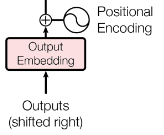

The main part is Multihead attention

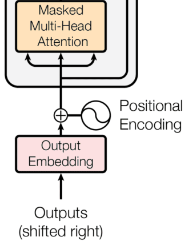

After number tokenisation the words are: `[1,2,3,4,5,6]` and the $\frac{softmax(Q*K)}{\sqrt{(d_k)}}$
(attention matrix) will look like:

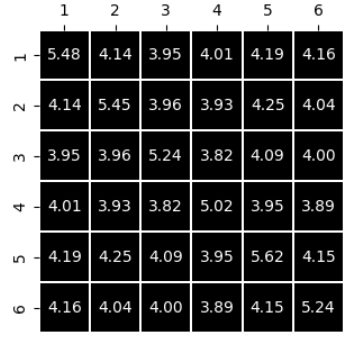

but how can first words has any relation with the upcoming words? How can the first word pay attention to upcoming words? That doesn't make sense and this will be **cheating** to have upcoming words attention weights. So to deal with this we create a **lookahead** mask that will make the attention of upcoming words **-inf** which then will be passed to **softmax**, making those attention score zero

$
\begin{bmatrix}
0 & -inf & -inf & -inf & -inf & -inf \\
0 & 0 & -inf & -inf & -inf & -inf \\
0 & 0 & 0 & -inf & -inf & -inf \\
0 & 0 & 0 & 0 &  -inf& -inf \\
0 & 0 & 0 & 0 & 0 & -inf \\
0 & 0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}
$

and we will add these which will result in

$
\begin{bmatrix}
5.48 & -inf & -inf & -inf & -inf & -inf \\
4.14 & 5.45 & -inf & -inf & -inf & -inf \\
3.95 & 3.96 & 5.24 & -inf & -inf & -inf \\
4.01 & 3.93 & 3.82 & 5.02 &  -inf& -inf \\
4.19 & 4.25 & 4.09 & 3.95 & 5.62 & -inf \\
4.16 & 4.04 & 4.00 & 3.89 & 4.15 & 5.24 \\
\end{bmatrix}
$

And after passing it through softmax function will get

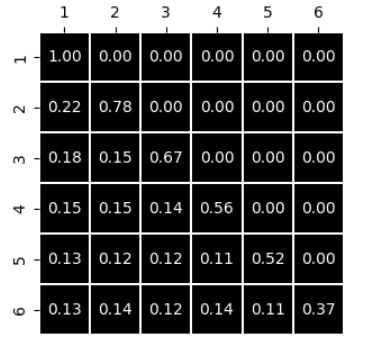

So this is how the the **lookahead** mask prevents **cheating** during training.

Then we will multiply this with V matrix and concatanate all the attention head and pass it through a linear layer just like we did in encoder and then we will add the residual connection + normalisation. All the same stuff.

but this time before feeding this to feedforward layer, we will calculate the cross attention. In cross attention we take <font color='brown'>encoder output</font> and pass them through two linear layers and we get <font color='brown'>Key</font> and <font color='brown'>value</font> matrix and for <font color='clamantine'>Query</font> matrix we pass the <font color='clamantine'>self attention output of decoder</font> through another linear layer.

Everything else is just the same

In [ ]:
from tensorflow.keras.layers import Layer, Dropout

# Implementing the Decoder Layer
class DecoderLayer(Layer):

  def __init__(self, h, d_k, d_v, d_model, d_ff, rate, **kwargs):

    super().__init__(**kwargs)
    self.multihead_attention1 = MultiHeadAttention(h, d_k, d_v, d_model)
    self.dropout1 = Dropout(rate)
    self.add_norm1 = AddNormalization()
    self.multihead_attention2 = MultiHeadAttention(h, d_k, d_v, d_model)
    self.dropout2 = Dropout(rate)
    self.add_norm2 = AddNormalization()
    self.feed_forward = FeedForward(d_ff, d_model)
    self.dropout3 = Dropout(rate)
    self.add_norm3 = AddNormalization()
  def call(self, x, encoder_output, lookahead_mask, padding_mask, training):

    # Multi-head attention layer
    multihead_output1 = self.multihead_attention1(x, x, x, lookahead_mask)       # Expected output shape = (batch_size, sequence_length, d_model)

    # Add in a dropout layer
    multihead_output1 = self.dropout1(multihead_output1, training=training)
    # Followed by an Add & Norm layer

    addnorm_output1 = self.add_norm1(x, multihead_output1)    # Expected output shape = (batch_size, sequence_length, d_model)

    # Followed by another multi-head attention layer
    multihead_output2 = self.multihead_attention2(addnorm_output1, encoder_output, encoder_output, padding_mask)

    # Add in another dropout layer
    multihead_output2 = self.dropout2(multihead_output2, training=training)

    # Followed by another Add & Norm layer
    addnorm_output2 = self.add_norm1(addnorm_output1, multihead_output2)

    # Followed by a fully connected layer
    feedforward_output = self.feed_forward(addnorm_output2)        # Expected output shape = (batch_size, sequence_length, d_model)

    # Add in another dropout layer
    feedforward_output = self.dropout3(feedforward_output, training=training)

    # Followed by another Add & Norm layer
    return self.add_norm3(addnorm_output2, feedforward_output)

# Implementing the Decoder
class Decoder(Layer):

  def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, pretrained_embedding_matrix, **kwargs):

    super().__init__(**kwargs)
    self.pos_encoding = PositionalEmbeddingLayer(sequence_length, vocab_size, d_model, pretrained_embedding_matrix)
    self.dropout = Dropout(rate)
    self.decoder_layer = [DecoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]

  def call(self, output_target, encoder_output, lookahead_mask, padding_mask, training):

    # Generate the positional encoding
    pos_encoding_output = self.pos_encoding(output_target)    # Expected output shape = (number of sentences, sequence_length, d_model)

    # Add in a dropout layer
    x = self.dropout(pos_encoding_output, training=training)

    for i, layer in enumerate(self.decoder_layer):

      x = layer(x, encoder_output, lookahead_mask, padding_mask, training)

    return x

## Transformer Model

In [ ]:
# from encoder import Encoder
# from decoder import Decoder
from tensorflow import math, cast, float32, linalg, ones, maximum, newaxis
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense

class TransformerModel(Model):

  def __init__(self, enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model,
               d_ff_inner, n, rate, src_pretrained_embedding_matrix, trgt_pretrained_embedding_matrix, **kwargs):

    super().__init__(**kwargs)
    # Set up the encoder\
    print('Transformer __init__ encoder vocab size', enc_vocab_size)
    print('Transformer __init__ decoder vocab size', dec_vocab_size)
    self.encoder = Encoder(enc_vocab_size, enc_seq_length, h, d_k, d_v, d_model, d_ff_inner, n, rate, src_pretrained_embedding_matrix)

    # Set up the decoder
    self.decoder = Decoder(dec_vocab_size, dec_seq_length, h, d_k, d_v, d_model, d_ff_inner, n, rate, trgt_pretrained_embedding_matrix)

    # Define the final dense layer
    self.model_last_layer = Dense(dec_vocab_size)

  def padding_mask(self, input):

    # Create mask which marks the zero padding values in the input by a 1.0
    mask = math.equal(input, 0)
    mask = cast(mask, float32)

    # The shape of the mask should be broadcastable to the shape of the attention weights that it will be masking later on
    padding_mask_output = mask[:, newaxis, newaxis, :]

    return padding_mask_output

  def lookahead_mask(self, shape):
    # Mask out future entries by marking them with a 1.0
    mask = 1 - linalg.band_part(ones((shape, shape)), -1, 0)
    return mask

  def call(self, encoder_input, decoder_input, training):

    # Create padding mask to mask the encoder inputs and the encoder
    # outputs in the decoder
    enc_padding_mask = self.padding_mask(encoder_input)

    # Create and combine padding and look-ahead masks to be fed into the decoder
    dec_in_padding_mask = self.padding_mask(decoder_input)

    dec_in_lookahead_mask = self.lookahead_mask(decoder_input.shape[1])

    dec_in_lookahead_mask = maximum(dec_in_padding_mask, dec_in_lookahead_mask)

    # Feed the input into the encoder
    encoder_output = self.encoder(encoder_input, enc_padding_mask, training)

    # Feed the encoder output into the decoder
    decoder_output = self.decoder(decoder_input, encoder_output, dec_in_lookahead_mask, enc_padding_mask, training)

    # Pass the decoder output through a final dense layer
    model_output = self.model_last_layer(decoder_output)
    return model_output

# data preperation

In [ ]:
!wget https://www.cfilt.iitb.ac.in/iitb_parallel/iitb_corpus_download/parallel.zip

--2023-07-30 12:36:39--  https://www.cfilt.iitb.ac.in/iitb_parallel/iitb_corpus_download/parallel.zip
Resolving www.cfilt.iitb.ac.in (www.cfilt.iitb.ac.in)... 103.21.127.134
Connecting to www.cfilt.iitb.ac.in (www.cfilt.iitb.ac.in)|103.21.127.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104534521 (100M) [application/zip]
Saving to: ‘parallel.zip’

parallel.zip        100%[===================>]  99.69M  33.7MB/s    in 3.0s    

2023-07-30 12:36:42 (33.7 MB/s) - ‘parallel.zip’ saved [104534521/104534521]



In [ ]:
!unzip /content/parallel.zip

Archive:  /content/parallel.zip
   creating: parallel-n/
  inflating: parallel-n/IITB.en-hi.en  
  inflating: parallel-n/IITB.en-hi.hi  


In [ ]:
i = 0
with open('/content/parallel-n/IITB.en-hi.en', 'r') as f:
    for line in f:
        print(line)
        i+=1
        if i>10:
          break

Give your application an accessibility workout

Accerciser Accessibility Explorer

The default plugin layout for the bottom panel

The default plugin layout for the top panel

A list of plugins that are disabled by default

Highlight duration

The duration of the highlight box when selecting accessible nodes

Highlight border color

The color and opacity of the highlight border.

Highlight fill color

The color and opacity of the highlight fill.



## English Text Preprocessing

In [ ]:
import string
import re
from unicodedata import normalize

def load_doc(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    return lines
def remove_hindi_words(text):
    hindi_pattern = re.compile(r'[^\x00-\x7F]')
    english_words = []
    for word in text.split():
        if not hindi_pattern.search(word):
            english_words.append(word)
    return ' '.join(english_words)

def tokenize_sentences_eng(lines):
    tokenized_sentences = []
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    table = str.maketrans('', '', string.punctuation)
    for line in lines:
        line = normalize('NFD', line).encode('ascii', 'ignore')
        line = line.decode('UTF-8')
        line = remove_hindi_words(line)  # Remove Hindi words
        line = line.split()
        line = [word.lower() for word in line]
        line = [word.translate(table) for word in line]
        line = [re_print.sub('', w) for w in line]
        line = [word for word in line if word.isalpha()]

        tokenized_sentences.append(line)
    return tokenized_sentences

def save_tokenized_data(tokenized_sentences, filename):
    with open(filename, 'w') as file:
        for tokenized_sentence in tokenized_sentences:
            line = ' '.join(tokenized_sentence)
            file.write(line + '\n')

In [ ]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [ ]:
%%time

# Load dataset
filename = '/content/parallel-n/IITB.en-hi.en'
doc = load_doc(filename)

with ProcessPoolExecutor() as executor:
    future = executor.submit( tokenize_sentences_eng, doc)

# You can retrieve the result of the function execution using the `result()` method:
tokenized_sentences = future.result()

# # Save tokenized sentences in a text file
output_filename = 'english.txt'
save_tokenized_data(tokenized_sentences, output_filename)

CPU times: user 8.27 s, sys: 1.68 s, total: 9.95 s
Wall time: 54.6 s


In [ ]:
def load_tokenized_data(filename):
    tokenized_sentences = []
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            sentence = line.strip()
            tokenized_sentences.append(sentence)
    return tokenized_sentences

# Load tokenized sentences from the text file
input_filename = 'english.txt'
english_sentences = load_tokenized_data(input_filename)

In [ ]:
print(len(english_sentences))
print(english_sentences[0])

1659083
give your application an accessibility workout


In [ ]:
del tokenized_sentences, input_filename, output_filename, doc, filename

## Hindi Text Preprocessing

In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('stopwords')
nltk.download('punkt')

# Text Cleaning
def clean_text(text):
    # Remove HTML tags, URLs, and special characters
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\u0900-\u097F\s]', '', text)
    hindi_text = re.sub(r'[^\u0900-\u097F\s]', '', text)
    return hindi_text

# Tokenization
def tokenize(text):
    tokens = word_tokenize(text)
    return tokens

# Normalization
def normalize(tokens):
    normalized_tokens = [token.lower() for token in tokens]
    return normalized_tokens

def tokenize_sentences_hindi(doc):
  tokenized_sentences = []
  for text in doc:
    text = clean_text(text)
    tokens = tokenize(text)
    normalised_tokens = normalize(tokens)
    tokenized_sentences.append(normalised_tokens)
  return tokenized_sentences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
%%time

# load dataset
filename = '/content/parallel-n/IITB.en-hi.hi'
doc = load_doc(filename)

with ProcessPoolExecutor() as executor:
    future = executor.submit(tokenize_sentences_hindi, doc)

# You can retrieve the result of the function execution using the `result()` method:
tokenized_sentences = future.result()

# # Save tokenized sentences in a text file
output_filename = 'hindi.txt'
save_tokenized_data(tokenized_sentences, output_filename)

CPU times: user 12.7 s, sys: 4.19 s, total: 16.9 s
Wall time: 3min 43s


In [ ]:
# Load tokenized sentences from the text file
input_filename = 'hindi.txt'
hindi_sentences = load_tokenized_data(input_filename)

In [ ]:
print(len(hindi_sentences))
print(hindi_sentences[0])

1659083
अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें


In [ ]:
del output_filename, input_filename, tokenized_sentences, doc, filename

In [ ]:
# %whos

In [ ]:
import sys

# Get the local variables
variables = list(locals().items())

# Sort the variables by size in descending order
sorted_variables = sorted(variables, key=lambda x: sys.getsizeof(x[1]), reverse=True)

# Print the sorted variables
for variable in sorted_variables:
    name, value = variable
    print(name, sys.getsizeof(value))


english_sentences 13533400
hindi_sentences 13533400
_i6 4240
_i5 4215
_i4 3943
_i7 3360
_i2 1772
ProcessPoolExecutor 1480
_i13 1400
TextVectorization 1072
Embedding 1072
Layer 1072
PositionEmbeddingFixedWeights 1072
DotProductAttention 1072
Dense 1072
MultiHeadAttention 1072
LayerNormalization 1072
ReLU 1072
Dropout 1072
AddNormalization 1072
FeedForward 1072
EncoderLayer 1072
Encoder 1072
DecoderLayer 1072
Decoder 1072
Model 1072
TransformerModel 1072
ThreadPoolExecutor 1072
SnowballStemmer 1072
_i19 1015
_i3 960
_i15 502
_i20 502
_i16 444
_i25 386
_ih 312
In 312
_i1 272
f 208
_i8 207
_i10 197
_i11 194
_i21 177
convert_to_tensor 144
matmul 144
cast 144
softmax 144
reshape 144
shape 144
transpose 144
ones 144
maximum 144
normalize 144
load_doc 144
remove_hindi_words 144
tokenize_sentences_eng 144
save_tokenized_data 144
load_tokenized_data 144
word_tokenize 144
clean_text 144
tokenize 144
tokenize_sentences_hindi 144
_ii 120
_i18 120
_i23 120
_i14 119
__doc__ 113
_i17 106
_iii 102
_i22

## Stats on both languages

We will only train on 100000 sentences and validate on 20000 sentences

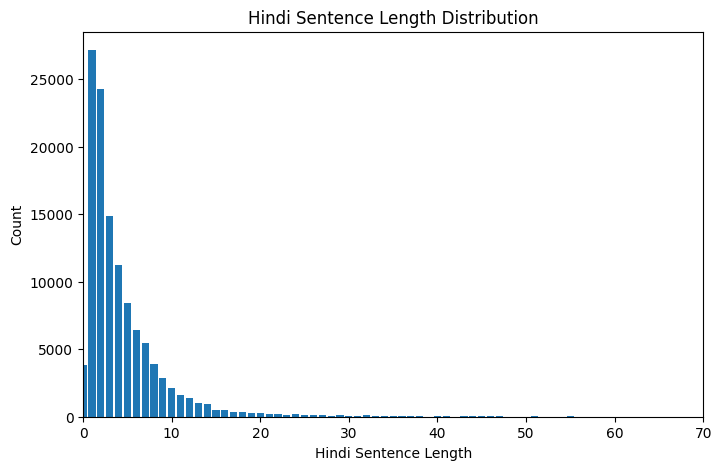

In [ ]:
hindi_sentences_len = [len(text.split()) for text in hindi_sentences[:120000]]
length_distribution = nltk.FreqDist(hindi_sentences_len)
import matplotlib.pyplot as plt
# Plot the sentence length distribution
plt.figure(figsize=(8, 5))
plt.bar(length_distribution.keys(), length_distribution.values())
plt.xlabel('Hindi Sentence Length')
plt.ylabel('Count')
plt.title('Hindi Sentence Length Distribution')

# Zoom in on the x-axis
plt.xlim(0, 70)  # Adjust the limits as needed

plt.show()

In [ ]:
import pandas as pd
# Create a Pandas Series from the sentence lengths
hindi_length_series = pd.Series(hindi_sentences_len)

# Calculate statistics
stats = hindi_length_series.describe()
percentile_98 = hindi_length_series.quantile(0.98)
print(stats)
print(percentile_98)

count    120000.000000
mean          4.424925
std           5.331201
min           0.000000
25%           1.000000
50%           3.000000
75%           6.000000
max         111.000000
dtype: float64
20.0


Based of the above stats the max length for hindi sentences will be 60 as 98% of the sentences fall under 60 words per sentences, we are not taking this value as 1133 (actual maximum length of a sentence in corpus) because that will be compuationally expensive and that too for just 1% of the data

In [ ]:
max_len_hindi = int(percentile_98)

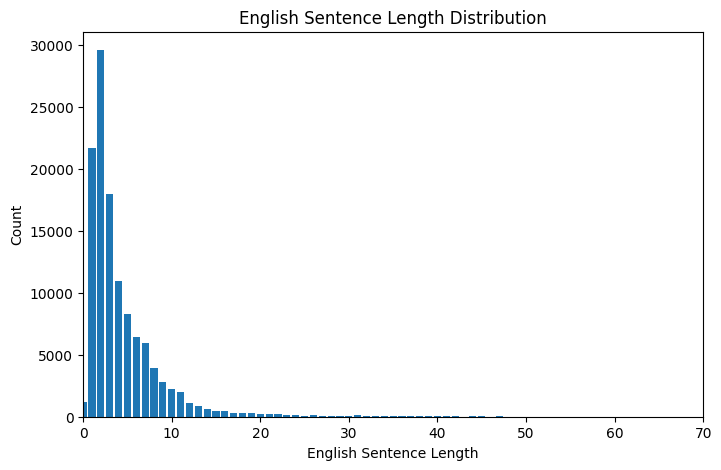

In [ ]:
eng_sentences_len = [len(text.split()) for text in english_sentences[:120000]]
length_distribution = nltk.FreqDist(eng_sentences_len)

# Plot the sentence length distribution
plt.figure(figsize=(8, 5))
plt.bar(length_distribution.keys(), length_distribution.values())
plt.xlabel('English Sentence Length')
plt.ylabel('Count')
plt.title('English Sentence Length Distribution')

# Zoom in on the x-axis
plt.xlim(0, 70)  # Adjust the limits as needed

plt.show()

In [ ]:
# Create a Pandas Series from the sentence lengths
eng_length_series = pd.Series(eng_sentences_len)

# Calculate statistics
stats = eng_length_series.describe()
percentile_98 = eng_length_series.quantile(0.98)
print(stats)
print(percentile_98)

count    120000.000000
mean          4.487592
std           5.215356
min           0.000000
25%           2.000000
50%           3.000000
75%           6.000000
max         119.000000
dtype: float64
19.0


We can apply the same logic in the english sentences as we applied in hindi ones

In [ ]:
max_len_english = int(percentile_98)

## splitting and preparing source language (English)

In [ ]:
# !wget https://www.cfilt.iitb.ac.in/iitb_parallel/iitb_corpus_download/dev_test.zip

--2023-07-05 12:52:56--  https://www.cfilt.iitb.ac.in/iitb_parallel/iitb_corpus_download/dev_test.zip
Resolving www.cfilt.iitb.ac.in (www.cfilt.iitb.ac.in)... 103.21.127.134
Connecting to www.cfilt.iitb.ac.in (www.cfilt.iitb.ac.in)|103.21.127.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 325882 (318K) [application/zip]
Saving to: ‘dev_test.zip’

dev_test.zip        100%[===================>] 318.24K   432KB/s    in 0.7s    

2023-07-05 12:52:58 (432 KB/s) - ‘dev_test.zip’ saved [325882/325882]



In [ ]:
# !unzip /content/dev_test.zip

Archive:  /content/dev_test.zip
   creating: dev_test/
  inflating: dev_test/dev.en         
  inflating: dev_test/test.en        
  inflating: dev_test/test.hi        
  inflating: dev_test/dev.hi         


In [ ]:
from pickle import load
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import convert_to_tensor, int64

class PrepareDataset:
  def __init__(self, train_sentences_len, val_sentences_len, source_max_len, target_max_len, vocab_size, **kwargs):
    super().__init__(**kwargs)

    self.train_sentences_len = train_sentences_len # Number of sentences to include in the dataset
    self.val_sentences_len = val_sentences_len
    self.source_max_len = source_max_len
    self.target_max_len = target_max_len
    self.vocab_size = vocab_size

  def reduce_vocab(self, tokenizer, vocab_size, target):

    word_counts = tokenizer.word_counts
    sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
    selected_words = sorted_words[:vocab_size - 1]  # Exclude one space for <unk>
    tokenizer.word_index = {word: index + 1 for index, word in enumerate(selected_words)}
    tokenizer.word_index['<unk>'] = vocab_size
    if target:
      tokenizer.word_index['<sos>'] = 1
      tokenizer.word_index['<eos>'] = 2
    tokenizer.oov_token = '<unk>'
    return tokenizer

  # Fit a tokenizer
  def create_tokenizer(self, dataset, vocab_size, target, padding_token='<pad>', padding_index=0):
    tokenizer = Tokenizer(oov_token='<unk>')
    tokenizer.fit_on_texts(dataset)
    tokenizer.word_index[padding_token] = padding_index
    tokenizer.index_word[padding_index] = padding_token
    return tokenizer

  def find_seq_length(self, dataset):
    return max(len(seq.split()) for seq in dataset)

  def find_vocab_size(self, tokenizer, dataset):
    return len(tokenizer.word_index)

  # Encode and pad the input sequences
  def encode_pad(self, dataset, tokenizer, seq_length):
    x = tokenizer.texts_to_sequences(dataset)
    x = pad_sequences(x, maxlen=seq_length, padding='post', dtype='int32')
    x = convert_to_tensor(x, dtype=int64)
    return x

  def __call__(self, source, target, **kwargs):

    # adding the start and end token only in target sentences

    for i in range(len(target)):
      target[i] = "<sos> " + target[i] + " <eos>"

    # Split the dataset
    source_train = source[:int(self.train_sentences_len)]
    source_val = source[int(self.train_sentences_len):int(self.train_sentences_len)+int(self.val_sentences_len)]

    target_train = target[:int(self.train_sentences_len)]
    target_val = target[int(self.train_sentences_len):int(self.train_sentences_len)+int(self.val_sentences_len)]

    # Prepare tokenizer for the encoder input
    enc_tokenizer = self.create_tokenizer(source_train, self.vocab_size, False)
    enc_vocab_size = self.find_vocab_size(enc_tokenizer, source_train)

    # Encode and pad the input sequences
    trainX = self.encode_pad(source_train, enc_tokenizer, self.source_max_len)
    valX = self.encode_pad(source_val, enc_tokenizer, self.source_max_len)

    # Prepare tokenizer for the decoder input
    dec_tokenizer = self.create_tokenizer(target_train, self.vocab_size, True)
    dec_vocab_size = self.find_vocab_size(dec_tokenizer, target_train)

    # Encode and pad the input sequences
    trainY = self.encode_pad(target_train, dec_tokenizer, self.target_max_len)
    valY = self.encode_pad(target_val, dec_tokenizer, self.target_max_len)

    return (trainX, trainY, valX, valY, enc_vocab_size, enc_tokenizer, dec_vocab_size, dec_tokenizer)

In [ ]:
dataset = PrepareDataset(100000, 20000, max_len_english, max_len_hindi, 60000)
trainX, trainY, valX, valY, enc_vocab_size, enc_tokenizer, dec_vocab_size, dec_tokenizer = dataset(source=english_sentences.copy(), target=hindi_sentences.copy())

In [ ]:
print('train data encoder input shape', trainX.shape)
print('train data decoder input/target combo shape', trainY.shape)
print('encoder vocabulary size', enc_vocab_size)
print('decoder vocabulary size', dec_vocab_size)

train data encoder input shape (100000, 19)
train data decoder input/target combo shape (100000, 19)
encoder vocabulary size 5582
decoder vocabulary size 6482


In [ ]:
type(trainX[0].numpy())

numpy.ndarray

In [ ]:
english_sentences[0]

'give your application an accessibility workout'

In [ ]:
print(enc_tokenizer.sequences_to_texts([trainX[10].numpy()]))
print(trainX[10])
print(dec_tokenizer.sequences_to_texts([trainY[10].numpy()]))
print(trainY[10])

['the color and opacity of the highlight fill <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
tf.Tensor(
[   2  116   15 1085    6    2  382  374    0    0    0    0    0    0
    0    0    0    0    0], shape=(19,), dtype=int64)
['sos हाइलाइट किया गया भराई का रंग और पारदर्शिता। eos <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
tf.Tensor(
[   2  689   33   39 1502   12  102   27 3287    3    0    0    0    0
    0    0    0    0    0], shape=(19,), dtype=int64)


The translation isn't 100% accurate but it should give us good enough results after training

In [ ]:
# Let's get the pretrained glove embeddings
!wget --no-check-certificate 'https://nlp.stanford.edu/data/glove.6B.zip'

# !kaggle datasets download -d thanakomsn/glove6b300dtxt
# !unzip '/content/glove6b300dtxt.zip'

--2023-07-30 11:29:06--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-07-30 11:29:07--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.05MB/s    in 2m 39s  

2023-07-30 11:31:46 (5.19 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!unzip /content/glove.6B.zip

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.hi.vec

--2023-07-30 11:37:13--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.hi.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.82, 13.35.7.128, 13.35.7.38, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 416644179 (397M) [binary/octet-stream]
Saving to: ‘wiki.hi.vec’

wiki.hi.vec         100%[===================>] 397.34M  37.3MB/s    in 11s     

2023-07-30 11:37:25 (35.9 MB/s) - ‘wiki.hi.vec’ saved [416644179/416644179]



In [ ]:
with open('/content/wiki.hi.vec','r') as f:
  for i, line in enumerate(f):
    print(line)
    if i == 10 :
      break

158016 300

</s> 0.11805 0.020802 -0.1089 -0.15894 -0.099375 0.18186 0.10915 -0.13444 0.088495 0.13883 0.0087136 0.000868 -0.15426 -0.11779 -0.19404 -0.09652 -0.0016641 0.018956 -0.061415 -0.067655 0.096204 0.11215 -0.032286 0.47692 0.30003 -0.045058 0.071621 -0.03294 0.15929 -0.20687 -0.116 0.11844 -0.04063 -0.11685 0.05468 0.011329 0.10962 -0.12171 -0.030407 -0.048362 0.12066 -0.089797 0.037743 -0.17441 0.16022 0.0015027 0.082437 -0.11796 0.14972 0.043381 0.010314 -0.039055 -0.16809 -0.075393 0.064941 0.016056 -0.022792 -0.0080583 0.13621 -0.070592 0.18616 0.24617 0.16976 0.14741 0.1235 -0.12475 -0.11184 0.14197 -0.24451 0.011281 0.23877 -0.14358 0.081527 0.061886 0.043097 0.15992 0.023049 -0.085767 -0.025619 0.15381 -0.28751 0.040967 -0.18054 0.10728 0.11467 -0.0030426 0.037164 -0.053903 0.14863 -0.076724 -0.013779 -0.0013568 0.18816 0.26511 -0.10453 -0.011901 0.13636 0.0047142 0.19787 0.030574 -0.059869 0.073519 0.12941 0.0089557 -0.057192 0.22919 -0.08126 -0.049841 -0.0011047 -0.0

Instead of this you can also use fasttext:

```python
!pip install fasttext
import fasttext
import fasttext.util
ft = fasttext.load_model('wiki.hi.vec')
word = "नृत्य"
print("Embedding Shape is {}".format(ft.get_word_vector(word).shape))
print("Nearest Neighbors to {} are:".format(word))
ft.get_nearest_neighbors(word)
```

In [ ]:
%%time
import numpy as np
from tqdm import tqdm
# here source language is english
word_to_index = dec_tokenizer.word_index
index_to_word = dec_tokenizer.index_word

# Load pre-trained GloVe embeddings
glove_file = "/content/wiki.hi.vec"
target_embeddings_index = {}
embedding_dim = 300  # Adjust based on the GloVe embedding dimension

with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = np.asarray(values[1:])
        target_embeddings_index[word] = embedding

# Create the embedding matrix
vocab_size = len(word_to_index)
unknown_words_glove = []
target_embedding_matrix = np.zeros((vocab_size, embedding_dim))
print(target_embedding_matrix.shape)
for word, index in tqdm(word_to_index.items()):

    embedding_vector = target_embeddings_index.get(word)
    if embedding_vector is not None:
        try:
            if type(embedding_vector[0]) == np.str_:
              embedding_vector = embedding_vector[int(embedding_vector.shape[0])-int(embedding_dim):int(embedding_vector.shape[0])]
            elif embedding_vector.shape[0] > embedding_dim:
                embedding_vector = embedding_vector[:embedding_dim]
            elif embedding_vector.shape[0] < embedding_dim:
                padding = np.zeros(embedding_dim - embedding_vector.shape[0])
                embedding_vector = np.concatenate((embedding_vector, padding))
            target_embedding_matrix[index] = embedding_vector
        except ValueError:
            print(f"Unable to process embedding vector for word '{word}, {index}'")

    else:
        unknown_words_glove.append(word)
        # Word not found in the pre-trained embeddings, initialize with random values
        target_embedding_matrix[index] = np.random.uniform(-0.2, 0.2, embedding_dim)

(39574, 300)


100%|██████████| 39574/39574 [00:02<00:00, 16078.49it/s]

CPU times: user 16.1 s, sys: 1.31 s, total: 17.4 s
Wall time: 17.4 s


In [ ]:
len(unknown_words_glove)

21859

In [ ]:
%%time
import numpy as np

# here source language is english
word_to_index = enc_tokenizer.word_index
index_to_word = enc_tokenizer.index_word

# Load pre-trained GloVe embeddings
glove_file = "/content/glove.6B.300d.txt"
source_embeddings_index = {}
embedding_dim = 300  # Adjust based on the GloVe embedding dimension

with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        source_embeddings_index[word] = embedding

# Create the embedding matrix
vocab_size = len(word_to_index)
unknown_words_glove = []
source_embedding_matrix = np.zeros((vocab_size, embedding_dim))
print(source_embedding_matrix.shape)
for word, index in tqdm(word_to_index.items()):

    embedding_vector = source_embeddings_index.get(word)
    if embedding_vector is not None:
        source_embedding_matrix[index] = embedding_vector

    # We will randomly assign the embeddings to words that are in glove embeddings
    else:
        unknown_words_glove.append(word)
        # Word not found in the pre-trained embeddings, initialize with random values
        source_embedding_matrix[index] = np.random.uniform(-0.2, 0.2, embedding_dim)

(34513, 300)


100%|██████████| 34513/34513 [00:00<00:00, 177080.74it/s]

CPU times: user 28.6 s, sys: 1.78 s, total: 30.4 s
Wall time: 30.7 s


In [ ]:
len(unknown_words_glove)

7488

In [ ]:
# for i, unk in enumerate(unknown_words_glove):
#   print(unk)
#   if i == 50:
#     break

# training process

In [ ]:
def loss_fcn(target, prediction):
  # Create mask so that the zero padding values are not included in the
  # computation of loss
  mask = math.logical_not(equal(target, 0))
  mask = cast(mask, float32)
  # Compute a sparse categorical cross-entropy loss on the unmasked values
  loss = sparse_categorical_crossentropy(target, prediction, from_logits=True) * mask
  # Compute the mean loss over the unmasked values
  return reduce_sum(loss) / reduce_sum(mask)

def accuracy_fcn(target, prediction):
  # Create mask so that the zero padding values are not included in the
  # computation of accuracy
  mask = math.logical_not(math.equal(target, 0))
  # Find equal prediction and target values, and apply the padding mask
  accuracy = equal(target, argmax(prediction, axis=2))
  accuracy = math.logical_and(mask, accuracy)
  # Cast the True/False values to 32-bit-precision floating-point numbers
  mask = cast(mask, float32)
  accuracy = cast(accuracy, float32)
  # Compute the mean accuracy over the unmasked values
  return reduce_sum(accuracy) / reduce_sum(mask)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.metrics import Mean
from tensorflow import data, train, math, reduce_sum, cast, equal, argmax, float32, GradientTape, TensorSpec, function, int64
from tensorflow.keras.losses import sparse_categorical_crossentropy
from time import time

In [ ]:
class LRScheduler(LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000, **kwargs):
    super().__init__(**kwargs)
    self.d_model = cast(d_model, float32)
    self.warmup_steps = cast(warmup_steps, float32)

  def __call__(self, step_num):
    # Linearly increasing the learning rate for the first warmup_steps, and
    # decreasing it thereafter
    step_num = cast(step_num, float32)
    arg1 = step_num ** -0.5
    arg2 = step_num * (self.warmup_steps ** -1.5)
    return (self.d_model ** -0.5) * math.minimum(arg1, arg2)

In [ ]:
# Define the model parameters
enc_seq_length = max_len_english
dec_seq_length = max_len_hindi
h = 8 # Number of self-attention heads
d_k = 64 # Dimensionality of the linearly projected queries and keys
d_v = 64 # Dimensionality of the linearly projected values
d_model = 300 # Dimensionality of model layers' outputs
d_ff = 2048 # Dimensionality of the inner fully connected layer
n = 6 # Number of layers in the encoder stack
# Define the training parameters
epochs = 20
batch_size = 256
beta_1 = 0.9
beta_2 = 0.98
epsilon = 1e-9
dropout_rate = 0.1

In [ ]:
optimizer = Adam(LRScheduler(d_model), beta_1, beta_2, epsilon)

# Prepare the dataset batches
train_dataset = data.Dataset.from_tensor_slices((trainX, trainY))
train_dataset = train_dataset.batch(batch_size)

# Prepare the validation dataset batches
val_dataset = data.Dataset.from_tensor_slices((valX, valY))
val_dataset = val_dataset.batch(batch_size)

# Create model
training_model = TransformerModel(enc_vocab_size, dec_vocab_size,
                                  enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate, None, None)

Transformer __init__ encoder vocab size 5582
Transformer __init__ decoder vocab size 6482


In [ ]:
# Include metrics monitoring
train_loss = Mean(name='train_loss')
train_accuracy = Mean(name='train_accuracy')
val_loss = Mean(name='val_loss')
val_accuracy = Mean(name='train_accuracy')

# Create a checkpoint object and manager to manage multiple checkpoints
ckpt = train.Checkpoint(model=training_model, optimizer=optimizer)
ckpt_manager = train.CheckpointManager(ckpt, "./checkpoints", max_to_keep=3)

# Initialise dictionaries to store the training and validation losses
train_loss_dict = {}
train_accuracy_dict = {}
val_loss_dict = {}
val_accuracy_dict = {}

In [ ]:
# Speeding up the training process
@tf.function
def train_step(encoder_input, decoder_input, decoder_output):

  with GradientTape() as tape:
    # Run the forward pass of the model to generate a prediction
    prediction = training_model(encoder_input, decoder_input, training=True)

    # Compute the training loss
    loss = loss_fcn(decoder_output, prediction)

    # Compute the training accuracy
    accuracy = accuracy_fcn(decoder_output, prediction)

  # Retrieve gradients of the trainable variables with respect to the training loss
  gradients = tape.gradient(loss, training_model.trainable_weights)

  # Update the values of the trainable variables by gradient descent
  optimizer.apply_gradients(zip(gradients, training_model.trainable_weights))

  train_loss(loss)
  train_accuracy(accuracy)


In [ ]:
start_time = time()
for epoch in range(epochs):
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()
  print("\nStart of epoch %d" % (epoch + 1))

  # Iterate over the dataset batches
  for step, (train_batchX, train_batchY) in enumerate(train_dataset):

    # Define the encoder and decoder inputs, and the decoder output
    encoder_input = train_batchX[:, :]
    decoder_input = train_batchY[:, :-1]
    decoder_output = train_batchY[:, 1:]

    train_step(encoder_input, decoder_input, decoder_output)

    if step % 50 == 0:
      print(f"Epoch {epoch+1} Step {step} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}")

  # Run a validation step after every epoch of training
  for val_batchX, val_batchY in val_dataset:
    # Define the encoder and decoder inputs, and the decoder output
    encoder_input = val_batchX[:, 1:]
    decoder_input = val_batchY[:, :-1]
    decoder_output = val_batchY[:, 1:]

    # Generate a prediction
    prediction = training_model(encoder_input, decoder_input, training=False)

    # Compute the validation loss
    loss = loss_fcn(decoder_output, prediction)
    val_loss(loss)
    accuracy = accuracy_fcn(decoder_output, prediction)
    val_accuracy(accuracy)
  # Print epoch number and accuracy and loss values at the end of every epoch
  print(f"Epoch {epoch+1}: Training Loss {train_loss.result():.4f}, Training Accuracy {train_accuracy.result():.4f}, Validation Loss {val_loss.result():.4f} Validatio Accuracy {val_accuracy.result():.4f}")

  # Save a checkpoint after every five epochs
  if (epoch + 1) % 5 == 0:
    save_path = ckpt_manager.save()
    print(f"Saved checkpoint at epoch {epoch+1}")
    print("Total time taken: %.2fs" % (time() - start_time))

    # Save the trained model weights
    training_model.save_weights("weights/wghts" + str(epoch + 1) + ".ckpt")
    train_loss_dict[epoch] = train_loss.result()
    train_accuracy_dict[epoch] = train_accuracy.result()
    val_loss_dict[epoch] = val_loss.result()
    val_accuracy_dict[epoch] = val_accuracy.result()

import pickle
# Save the training loss values
with open('./train_loss.pkl', 'wb') as file:
  pickle.dump(train_loss_dict, file)

# Save the validation loss values
with open('./val_loss.pkl', 'wb') as file:
  pickle.dump(val_loss_dict, file)

# Save the training loss values
with open('./train_accuracy.pkl', 'wb') as file:
  pickle.dump(train_accuracy_dict, file)

# Save the validation loss values
with open('./val_accuracy.pkl', 'wb') as file:
  pickle.dump(val_accuracy_dict, file)

print("Total time taken: %.2fs" % (time() - start_time))


Start of epoch 1
Epoch 1 Step 0 Loss 8.8557 Accuracy 0.0000
Epoch 1 Step 50 Loss 8.4348 Accuracy 0.1485
Epoch 1 Step 100 Loss 7.9456 Accuracy 0.2043
Epoch 1 Step 150 Loss 7.7796 Accuracy 0.1965
Epoch 1 Step 200 Loss 7.6011 Accuracy 0.1961
Epoch 1 Step 250 Loss 7.3814 Accuracy 0.1988
Epoch 1 Step 300 Loss 7.1624 Accuracy 0.2005
Epoch 1 Step 350 Loss 6.9858 Accuracy 0.1979
Epoch 1: Training Loss 6.8608, Training Accuracy 0.1984, Validation Loss 5.5692

Start of epoch 2
Epoch 2 Step 0 Loss 6.1790 Accuracy 0.2342
Epoch 2 Step 50 Loss 5.6850 Accuracy 0.2707
Epoch 2 Step 100 Loss 5.3215 Accuracy 0.2698
Epoch 2 Step 150 Loss 5.4185 Accuracy 0.2443
Epoch 2 Step 200 Loss 5.4920 Accuracy 0.2384
Epoch 2 Step 250 Loss 5.4622 Accuracy 0.2370
Epoch 2 Step 300 Loss 5.3919 Accuracy 0.2380
Epoch 2 Step 350 Loss 5.3503 Accuracy 0.2377
Epoch 2: Training Loss 5.3314, Training Accuracy 0.2375, Validation Loss 5.2795

Start of epoch 3
Epoch 3 Step 0 Loss 5.8874 Accuracy 0.2525
Epoch 3 Step 50 Loss 5.0492 A

The validation loss is decreasing so this can still be trained more

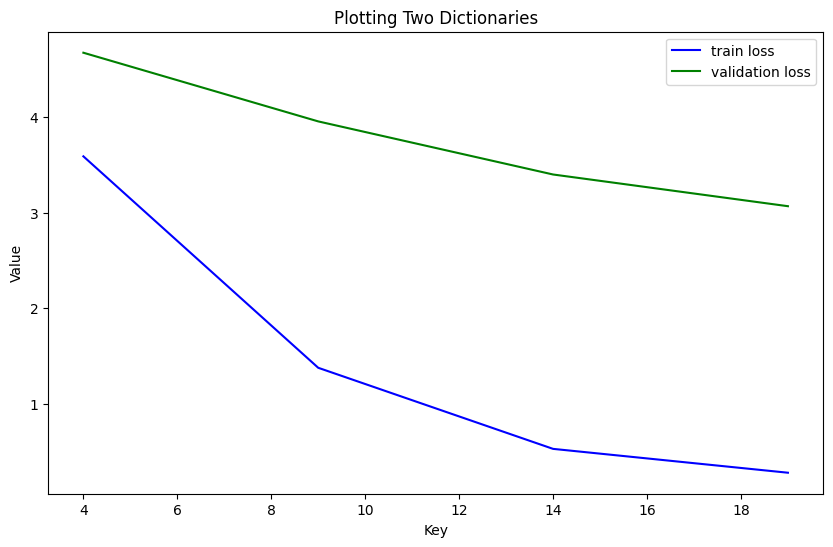

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

# Plot dict1
plt.plot(list(train_loss_dict.keys()), list(train_loss_dict.values()), label='train loss', color='blue')

# Plot dict2
plt.plot(list(val_loss_dict.keys()), list(val_loss_dict.values()), label='validation loss', color='green')

plt.xlabel('Key')
plt.ylabel('Value')
plt.title('Plotting Two Dictionaries')
plt.legend()
plt.show()

## Inference

In [ ]:
training_model.save_weights("weights/wghts" + str(15) + ".ckpt")

In [ ]:
from pickle import load
from tensorflow import Module
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import convert_to_tensor, int64, TensorArray, argmax, newaxis, transpose

inferencing_model = TransformerModel(enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff, n, 0, None, None)

class Translate(Module):

  def __init__(self, inferencing_model, **kwargs):

    super().__init__(**kwargs)
    self.transformer = inferencing_model

  def load_tokenizer(self, name):
    with open(name, 'rb') as handle:
      return load(handle)

  def __call__(self, sentence, enc_tokenizer, dec_tokenizer):

    # Prepare the input sentence by tokenizing, padding and converting to tensor
    encoder_input = enc_tokenizer.texts_to_sequences(sentence)
    encoder_input = pad_sequences(encoder_input, maxlen=5, padding='post')
    encoder_input = convert_to_tensor(encoder_input, dtype=int64)

    # Prepare the output <START> token by tokenizing, and converting to tensor
    output_start = dec_tokenizer.texts_to_sequences(["sos"])
    output_start = convert_to_tensor(output_start[0], dtype=int64)
    # Prepare the output <EOS> token by tokenizing, and converting to tensor
    output_end = dec_tokenizer.texts_to_sequences(["eos"])

    output_end = convert_to_tensor(output_end[0], dtype=int64)
    # Prepare the output array of dynamic size
    decoder_output = TensorArray(dtype=int64, size=0, dynamic_size=True)
    decoder_output = decoder_output.write(0, output_start)

    for loop_count, i in enumerate(range(dec_seq_length)):
      print(loop_count)
      # Predict an output token
      prediction = self.transformer(encoder_input,transpose(decoder_output.stack()), training=False)
      prediction = prediction[:, -1, :]
      # Select the prediction with the highest score
      predicted_id = argmax(prediction, axis=-1)
      predicted_id = predicted_id[0][newaxis]
      # Write the selected prediction to the output array at the next
      # available index
      decoder_output = decoder_output.write(i + 1, predicted_id)
      # Break if an <EOS> token is predicted
      if predicted_id == output_end:
        break
    output = transpose(decoder_output.stack())[0]

    output = output.numpy()
    output_str = []

    # Decode the predicted tokens into an output string
    for i in range(output.shape[0]):
      key = output[i]
      output_str.append(dec_tokenizer.index_word[key])

    return output_str

Transformer __init__ encoder vocab size 5582
Transformer __init__ decoder vocab size 6482


In [ ]:
# Sentence to translate
sentence = [english_sentences[101000]]
print(sentence)

['move to folder']


In [ ]:
# dec_tokenizer.get_config()

In [ ]:
# Load the trained model's weights at the specified epoch
inferencing_model.load_weights('/content/weights/wghts20.ckpt')

# Create a new instance of the 'Translate' class
translator = Translate(inferencing_model)

# Translate the input sentence
print(translator(sentence, enc_tokenizer, dec_tokenizer))

encoder input shape (1, 5)
decoder output <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x7eb52e309600>
0
1
2
3
['sos', 'फ़ोल्डर', 'में', 'खिसकाएँ', 'eos']


Great!!